In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
path = os.path.abspath('/content/gdrive/Shared drives/2040_project/LSY ARCHIVE/models')
# os.mkdir(os.path.join(path, 'bw_4thIter'))
# path = os.path.join(path, 'bw_4thIter')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# # this part will prevent tensorflow to allocate all the avaliable GPU Memory
# # backend
%tensorflow_version 2.x
import tensorflow as tf
# from keras import backend as k

# # Don't pre-allocate memory; allocate as-needed
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

# # Create a session with the above options specified.
# k.tensorflow_backend.set_session(tf.Session(config=config))

In [4]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, SpatialDropout2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from keras.layers import Concatenate
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()

# clustering
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans
from sklearn.metrics import mean_squared_error
from scipy import spatial


import math

Using TensorFlow backend.


# Load Model

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 100
l = 12
num_filter = 36 #added 24 more filters
compression = 0.5 
dropout_rate = 0.2
img_height, img_width, channel = 32, 32, 3

In [0]:
# Dense Block
# removed the dropout
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #if dropout_rate>0:
         # Conv2D_3_3 = Dropout2D(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False, kernel_regularizer = regularizers.l1() ,padding='same')(relu)
    #if dropout_rate>0:
      #Conv2D_BottleNeck = Dropout2D(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
# converted the last Dense Layer to a Fully Convolution N/w as use of Dense Layer was prohibited
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    temp = Conv2D(num_classes, kernel_size = (2,2))(AvgPooling)
    output = Activation('softmax')(temp)
    flat = Flatten()(output)
    
    return flat

In [0]:
num_filter = 36
dropout_rate = 0.2
l= 12
input = Input(shape=(img_height, img_width, channel))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [10]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 36)   972         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 36)   144         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 36)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
model.load_weights(path + '/190epochs.h5')

# Load Image

In [12]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step


(32, 32, 3)
(1, 32, 32, 3)


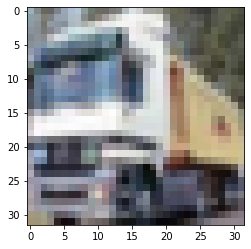

In [13]:
img_tensor = x_train[1]
print(img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
print(img_tensor.shape)
plt.imshow(img_tensor[0])

In [0]:
img_tensor.shape

(1, 32, 32, 3)

## Grayscale Feature Map

In [0]:
# Extracts the outputs of the top 1 layers:
layer_outputs = [layer.output for layer in model.layers[:2]]
# Creates a model that will return these outputs, given the model input:
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [0]:
activation_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 36)        972       
Total params: 972
Trainable params: 972
Non-trainable params: 0
_________________________________________________________________


(1, 32, 32, 36)


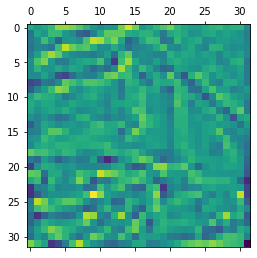

In [0]:

# This will return a list of 5 Numpy arrays:
# one array per layer activation
# make predictions
activations = activation_model.predict(img_tensor)
# get the prediction of the first layer
first_layer_activation = activations[1]
print(first_layer_activation.shape)
# visualize feature map of filter #0
plt.matshow(first_layer_activation[0, :, :, 20], cmap='viridis')
plt.show()

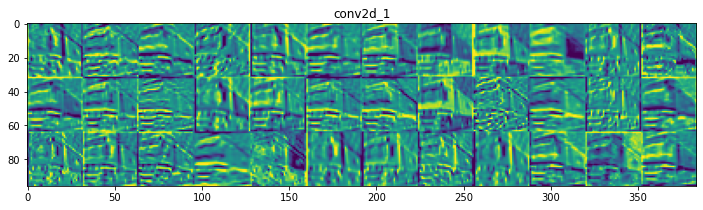

In [0]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[1:2]:
    layer_names.append(layer.name)

images_per_row = 12

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations[1:]):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()



## Visualizing filters

In [0]:
from keras import backend as K
layer_name = 'conv2d_1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [0]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [0]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 32, 32, 3))])

In [0]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 128, 128, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def generate_pattern(layer_name, filter_index, size=32):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 100 steps
    step = 0.1
    for i in range(200):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

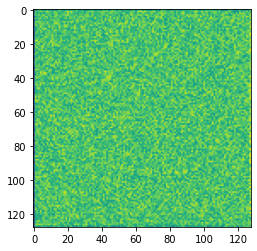

In [0]:
test_img = generate_pattern('conv2d_1', 0, size = 128)
test_img = np.dot(test_img[...,:3], [0.299, 0.587, 0.114]) / 255
plt.imshow(test_img)
plt.show()

### Black and White Filter Visualization

In [0]:
model.load_weights(path + '/190epochs.h5')

In [0]:
for layer_name in ['conv2d_1']:
    size = 128
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((6 * size + 7 * margin, 6 * size + 7 * margin))

    for i in range(6):  # iterate over the rows of our results grid
        for j in range(6):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 4)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 6), size=size)

            # convert to grayscale
            filter_img = np.dot(filter_img[...,:3], [0.299, 0.587, 0.114])

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end] = filter_img/255
            #print(np.amin(filter_img[:]), np.amax(filter_img[:]))

    # Display the results grid
    print(layer_name)
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
for layer_name in ['conv2d_1']:
    size = 128
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((6 * size + 7 * margin, 6 * size + 7 * margin, 3))

    for i in range(6):  # iterate over the rows of our results grid
        for j in range(6):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 6), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img/255
            #print(np.amin(filter_img[:]), np.amax(filter_img[:]))

    # Display the results grid
    print(layer_name)
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Another Modified Version

In [0]:
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()

def deprocess_image_grayscale_for_plot(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')

    # convert to grayscale by averaging across 3 channels
    # x = np.mean(x, axis=2)
    x = np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])
    return x


def deprocess_image_grayscale(x):
    
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.6
    
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to grayscale by averaging across 3 channels
    # x = np.mean(x, axis=2)
    x = np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])
    return x


def deprocess_image_color(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def generate_pattern(model, layer_name, filter_index, size=32, grayscale=True, for_plot=False):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 0.2
    for i in range(300):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]

    if grayscale:
        if not for_plot:
            return deprocess_image_grayscale(img)
        else:
            return deprocess_image_grayscale_for_plot(img)
    return deprocess_image_color(img)

In [0]:
def plot_filters(model_name, layer_list, img_size, mar, row = 3, col = 6, greyscale_flag = True, plot_flag = True, col_customized=None):

    for layer_name in layer_list:
        size = img_size
        margin = mar
        for_trans = []
        if not greyscale_flag:
            results = np.zeros((row * size + 7 * margin, col * size + 7 * margin, 3))
        else:
            # This a empty (black) image where we will store our results.
            results = np.zeros((row * size + 7 * margin, col * size + 7 * margin))

        for i in range(row):  # iterate over the rows of our results grid
            for j in range(col):  # iterate over the columns of our results grid
                # Generate the pattern for filter `i + (j * 6)` in `layer_name`
                
                filter_img = generate_pattern(model_name, layer_name, j + (i * row), size=size, grayscale=greyscale_flag, for_plot=plot_flag)
                  
                # Put the result in the square `(i, j)` of the results grid
                horizontal_start = i * size + i * margin
                horizontal_end = horizontal_start + size
                vertical_start = j * size + j * margin
                vertical_end = vertical_start + size
                if not greyscale_flag:
                    results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img/255
                else:
                    results[horizontal_start: horizontal_end, vertical_start: vertical_end] = filter_img / 255
                #print(np.amin(filter_img[:]), np.amax(filter_img[:]))
            print('Finished filter no.', (i+1) * row, "in", layer_name, end= '.  ')
        # Display the results grid
        print(layer_name)
        plt.figure(figsize=(15, 15))
        if col_customized:
            plt.imshow(results, cmap=col_customized)
        else:
            plt.imshow(results)
        plt.colorbar()
        plt.show()

Finished filter no. 5 in conv2d_14  Finished filter no. 8 in conv2d_14  Finished filter no. 11 in conv2d_14  conv2d_14


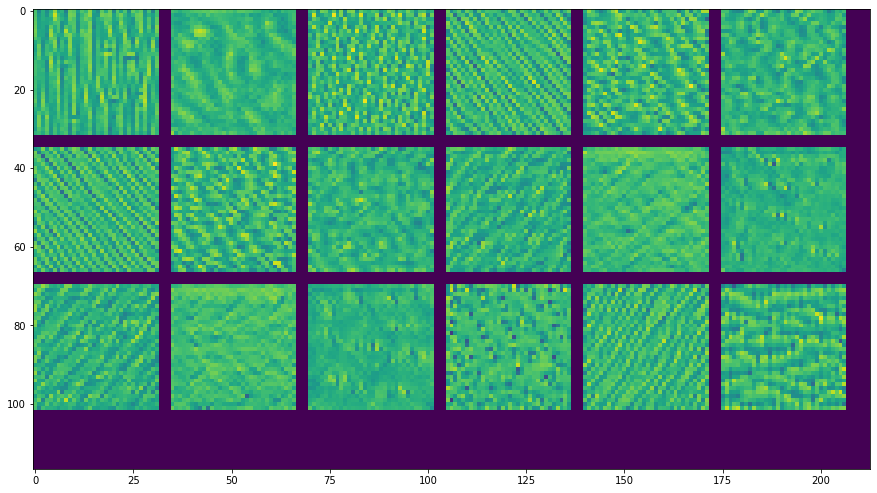

In [0]:
plot_filters(model, ['conv2d_14'], 32, 3, row = 3, col = 6, greyscale_flag = True)

Finished filter no. 5 in conv2d_3.  Finished filter no. 8 in conv2d_3.  Finished filter no. 11 in conv2d_3.  conv2d_3


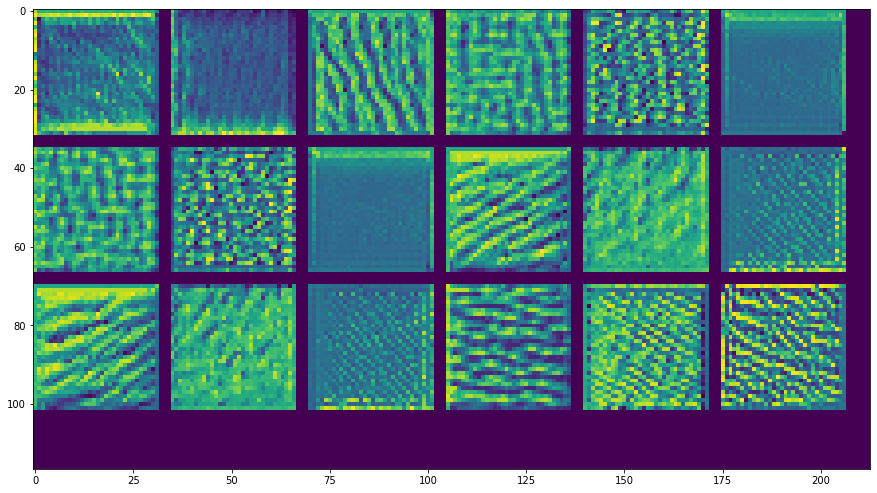

In [0]:
plot_filters(model, ['conv2d_3'], 32, 3, row = 3, col = 6, greyscale_flag = True, plot_flag=False)

Finished filter no. 6 in conv2d_1.  Finished filter no. 12 in conv2d_1.  Finished filter no. 18 in conv2d_1.  Finished filter no. 24 in conv2d_1.  Finished filter no. 30 in conv2d_1.  Finished filter no. 36 in conv2d_1.  conv2d_1


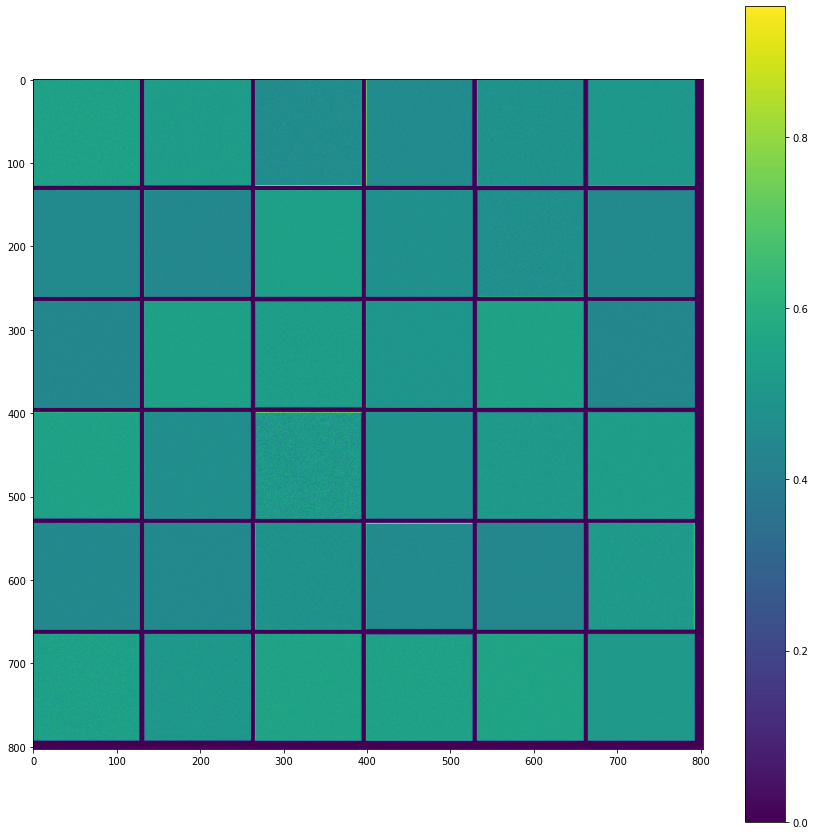

In [29]:
plot_filters(model, ["conv2d_1"], 128, 5, row = 6, col = 6, greyscale_flag = True, plot_flag = True)

Finished filter no. 6 in conv2d_1.  Finished filter no. 12 in conv2d_1.  Finished filter no. 18 in conv2d_1.  Finished filter no. 24 in conv2d_1.  Finished filter no. 30 in conv2d_1.  Finished filter no. 36 in conv2d_1.  conv2d_1


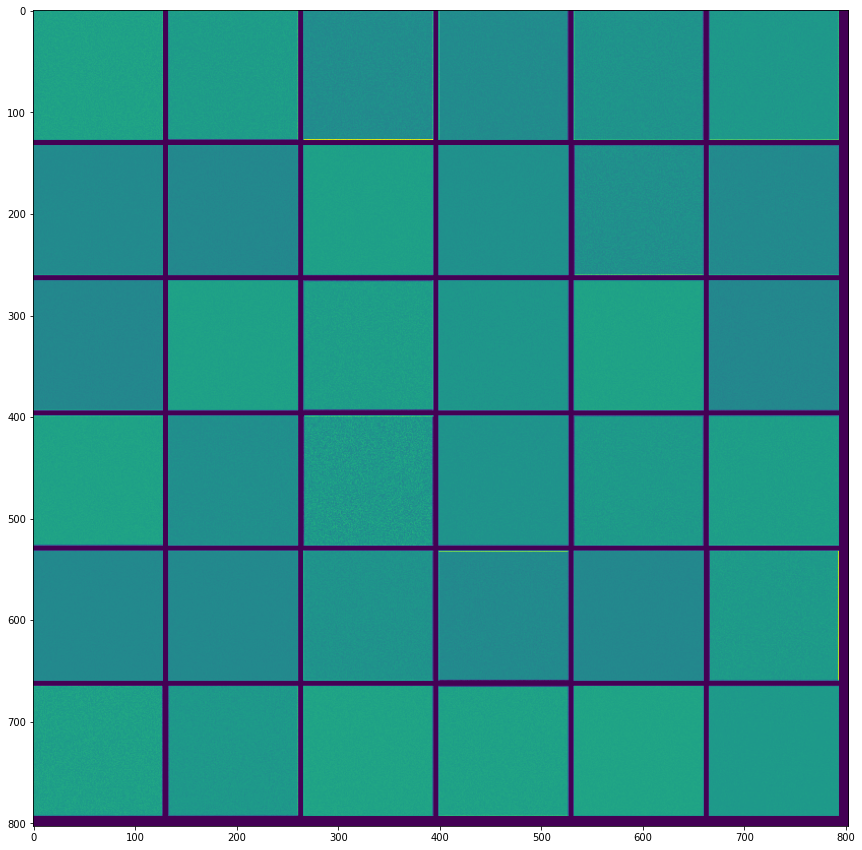

In [19]:
plot_filters(model, ["conv2d_1"], 128, 5, row = 6, col = 6, greyscale_flag = True, plot_flag = True)

Finished filter no. 1 in conv2d_1.  conv2d_1


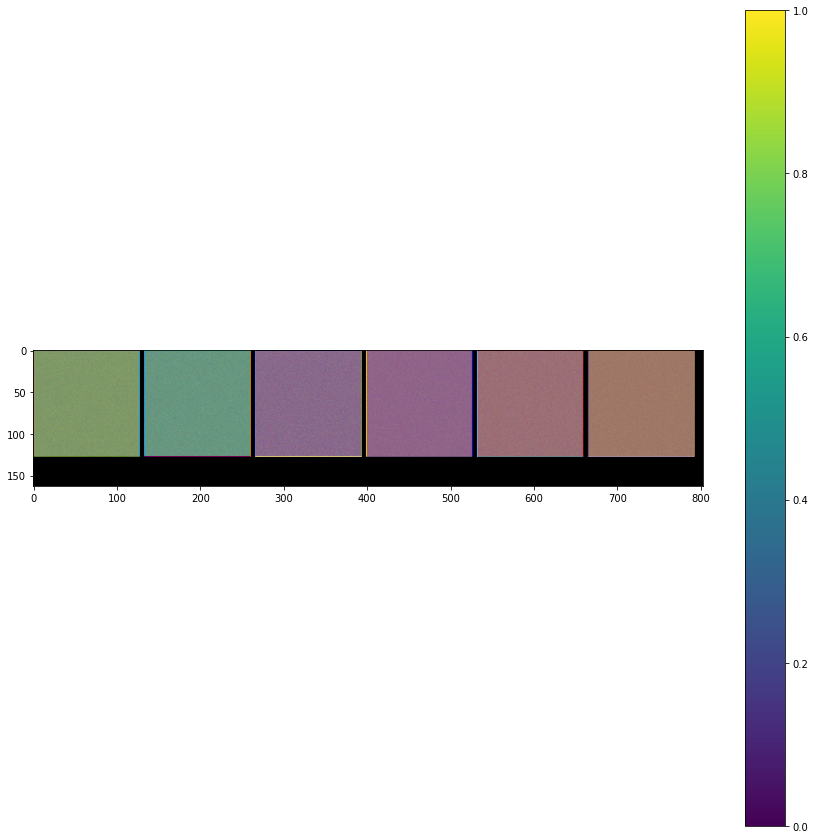

In [31]:
plot_filters(model, ["conv2d_1"], 128, 5, row = 1, col = 6, greyscale_flag = False, plot_flag = True)

### Try: changing input noise to 64






In [0]:
weights_list = model.get_weights()

In [0]:
num_filter = 36
dropout_rate = 0.2
l= 12
input = Input(shape=(64, 64, channel))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = Last_Block
model_64 = Model(inputs=[input], outputs=[output])
model_64.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 64, 64, 36)   972         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 64, 64, 36)   144         conv2d_54[0][0]                  
__________________________________________________________________________________________________
activation_54 (Activation)      (None, 64, 64, 36)   0           batch_normalization_53[0][0]     
____________________________________________________________________________________________

In [0]:
len(weights_list)

262

In [0]:
model_64.set_weights(weights_list)

In [0]:
judge = []
for i in range(256):
  v = model_64.get_weights()[i] ==  model.get_weights()[i]
  judge.append(v.all())
sum(judge)

256

Finished filter no. 3 in conv2d_2.  Finished filter no. 6 in conv2d_2.  Finished filter no. 9 in conv2d_2.  conv2d_2


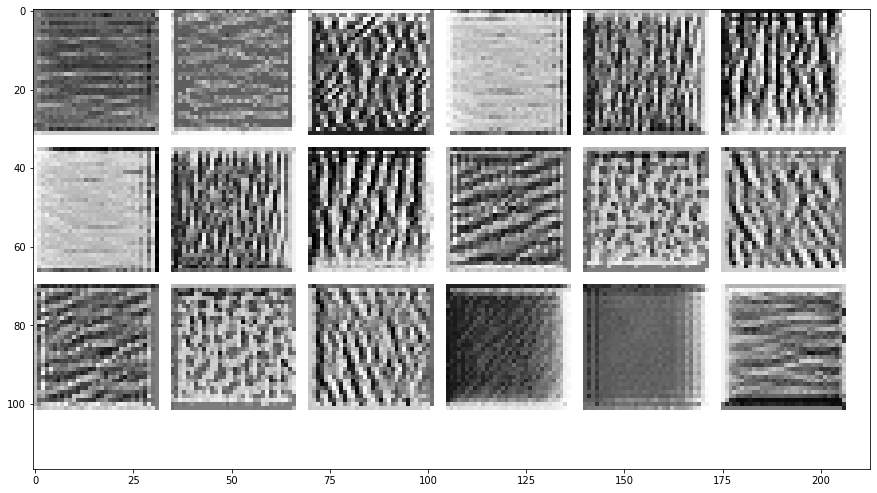

Finished filter no. 3 in conv2d_14.  Finished filter no. 6 in conv2d_14.  Finished filter no. 9 in conv2d_14.  conv2d_14


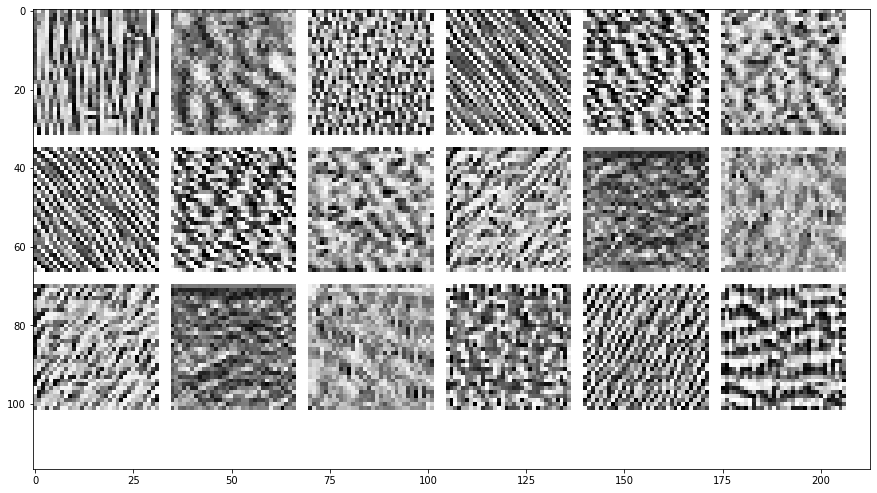

In [22]:
plot_filters(model, ['conv2d_2', 'conv2d_14'], 32, 3, row = 3, col = 6, greyscale_flag = True, plot_flag = False, col_customized='Greys')

In [0]:
plot_filters(model_64, ['conv2d_55', 'conv2d_56', 'conv2d_57', 'conv2d_58',  'conv2d_59'], 64, 3, row = 3, col = 6, greyscale_flag = True)

## Clustering Kernels

### Conv2d_14(the conv at the first transition layer)

In [0]:
# Get filter information to an array
def get_filter_array(model_name, layer_name, filter_num):
    filter_collection = []
    for i in range( filter_num):
        filter_img_temp = generate_pattern(model_name, layer_name, i, size=32, grayscale=True, for_plot=False)
        filter_collection.append(filter_img_temp)
    filter_collection = np.array(filter_collection)
    return filter_collection

In [0]:
conv2d_1 = get_filter_array(model, 'conv2d_1', 36)

KeyboardInterrupt: ignored

### Image Euclidean Distance (IMED)

In [0]:
def get_G(img_h, r):
    G_matrix = np.zeros((img_h**2, img_h**2))
    for i1 in range(img_h):
        for i2 in range(img_h):
            for j1 in range(img_h):
                for j2 in range(img_h):
                    pixel_dist = 1/(2*math.pi*(r**2)) * math.exp(-((i1-i2)**2 + (j1-j2)**2)/(2*r**2))
                    G_matrix[img_h*i1+j1, img_h*i2+j2] = pixel_dist
    return G_matrix
G = get_G(32, 1)
def get_imed(img1, img2):
    img1 = img1.flatten()
    img2 = img2.flatten()
    distance = math.sqrt(np.dot(np.dot(np.transpose(img1-img2), G), (img1-img2)))
    return distance

In [0]:
def calculate_dist(filter_collection, method="mse"):
    filter_num = filter_collection.shape[0]
    print("Calculated Distance Matrix Using", method, "Method.")
    print("Filter number:", filter_num)
    if method == "ssim": # calculate distance matrix using ssim
        filter_distance_matrix_ssim = np.zeros((filter_num, filter_num))
        for i in range(filter_num):
            for j in range(filter_num):
                filter_distance_matrix_ssim[i, j] = ssim(filter_collection[i], filter_collection[j])
        filter_distance_matrix_ssim = 1 - filter_distance_matrix_ssim
        return filter_distance_matrix_ssim

    if method == "mse": # calculate distance matrix using mse
        filter_distance_matrix_mse = np.zeros((filter_num, filter_num))
        for i in range(filter_num):
            for j in range(filter_num):
                filter_distance_matrix_mse[i, j] = mean_squared_error(filter_collection[i].flatten(), filter_collection[j].flatten())
        return filter_distance_matrix_mse

    if method == "consine": # calculate distance matrix using cosine
        filter_distance_matrix_cosine = np.zeros((filter_num, filter_num))
        for i in range(filter_num):
            for j in range(filter_num):
                filter_distance_matrix_cosine[i, j] = \
                1 - spatial.distance.cosine(filter_collection[i].flatten(), filter_collection[j].flatten())
        filter_distance_matrix_cosine = 1 - filter_distance_matrix_cosine
        return filter_distance_matrix_cosine
    
    if method == "brightness": # calculate distance matrix using brightness
        filter_distance_matrix_brightness = np.zeros((filter_num, filter_num))
        for i in range(filter_num):
            for j in range(filter_num):
                filter_distance_matrix_brightness[i, j] = \
                np.sum(filter_collection[i]) - np.sum(filter_collection[j])
        filter_distance_matrix_brightness = mmscaler.fit_transform(filter_distance_matrix_brightness.flatten().reshape(-1, 1)).reshape((filter_num, filter_num))
        return filter_distance_matrix_brightness
    if method == "imed":
        filter_distance_matrix_imed = np.zeros((filter_num, filter_num))
        for i in range(filter_num):
            for j in range(filter_num):
                filter_distance_matrix_imed[i, j] = get_imed(filter_collection[i].flatten(), filter_collection[j].flatten())
        return filter_distance_matrix_imed

In [0]:
conv2d_1_mse = calculate_dist(conv2d_1, method="mse")

In [0]:
def get_cluster_(distance_mat, weight, row, col, min_samp=1):
    h = len(distance_mat)
    distance_mat = mmscaler.fit_transform(distance_mat.flatten().reshape(-1,1)).reshape(h, h)
    std = np.std([distance_mat[i, j] for i in range(h) for j in range(h) if i != j])
    clustering = DBSCAN(eps=weight, 
                    min_samples=min_samp, metric='precomputed').fit(distance_mat)
    filter_clusters = clustering.labels_
    result = filter_clusters.reshape((row, col))
    print(result)
    return result

In [0]:
mmscaler.fit_transform(conv2d_1_mse.flatten().reshape(-1,1)).reshape(h, h)

array([[0.        , 0.04508894, 0.33952338, ..., 0.08322588, 0.05161126,
        0.01313244],
       [0.04508894, 0.        , 0.26965874, ..., 0.17591954, 0.0294253 ,
        0.02257239],
       [0.33952338, 0.26965874, 0.        , ..., 0.58360399, 0.16167416,
        0.28106806],
       ...,
       [0.08322588, 0.17591954, 0.58360399, ..., 0.        , 0.17631946,
        0.09065515],
       [0.05161126, 0.0294253 , 0.16167416, ..., 0.17631946, 0.        ,
        0.02236215],
       [0.01313244, 0.02257239, 0.28106806, ..., 0.09065515, 0.02236215,
        0.        ]])

### Conv2D_1

In [0]:
conv2d_1_imed = calculate_dist(conv2d_1, method="imed")
conv2d_1_mse = calculate_dist(conv2d_1, method="mse")

Calculated Distance Matrix Using imed Method.
Filter number: 36
Calculated Distance Matrix Using mse Method.
Filter number: 36


In [0]:
get_cluster_(conv2d_1_imed, weight=30, row=6, col=6, min_samp=1)

[[ 0  0  1  2  3  4]
 [ 5  6  0  6  7  8]
 [ 9  0 10 11  0  8]
 [ 0  8 12  8 13  0]
 [ 6  6  3 14  6 15]
 [16 15 17 18  0  0]]


Finished filter no. 5 in conv2d_1.  Finished filter no. 11 in conv2d_1.  Finished filter no. 17 in conv2d_1.  Finished filter no. 23 in conv2d_1.  Finished filter no. 29 in conv2d_1.  Finished filter no. 35 in conv2d_1.  conv2d_1


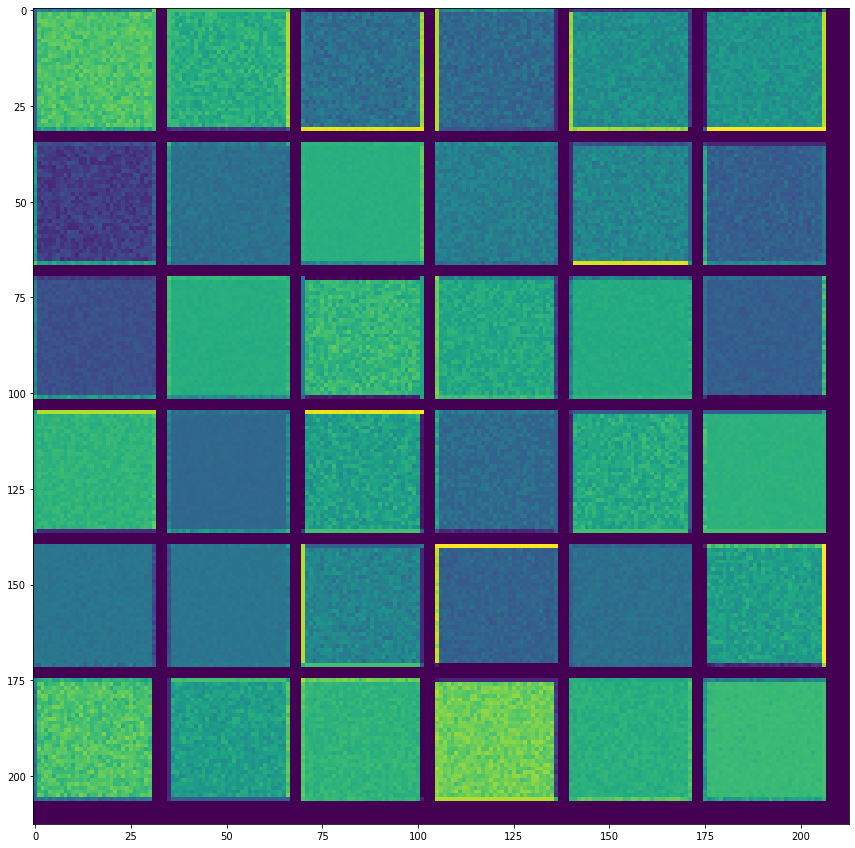

In [0]:
plot_filters(model, ['conv2d_1'], 32, 3, row = 6, col = 6, greyscale_flag = True, plot_flag=False)

Finished filter no. 5 in conv2d_1.  Finished filter no. 11 in conv2d_1.  Finished filter no. 17 in conv2d_1.  Finished filter no. 23 in conv2d_1.  Finished filter no. 29 in conv2d_1.  Finished filter no. 35 in conv2d_1.  conv2d_1


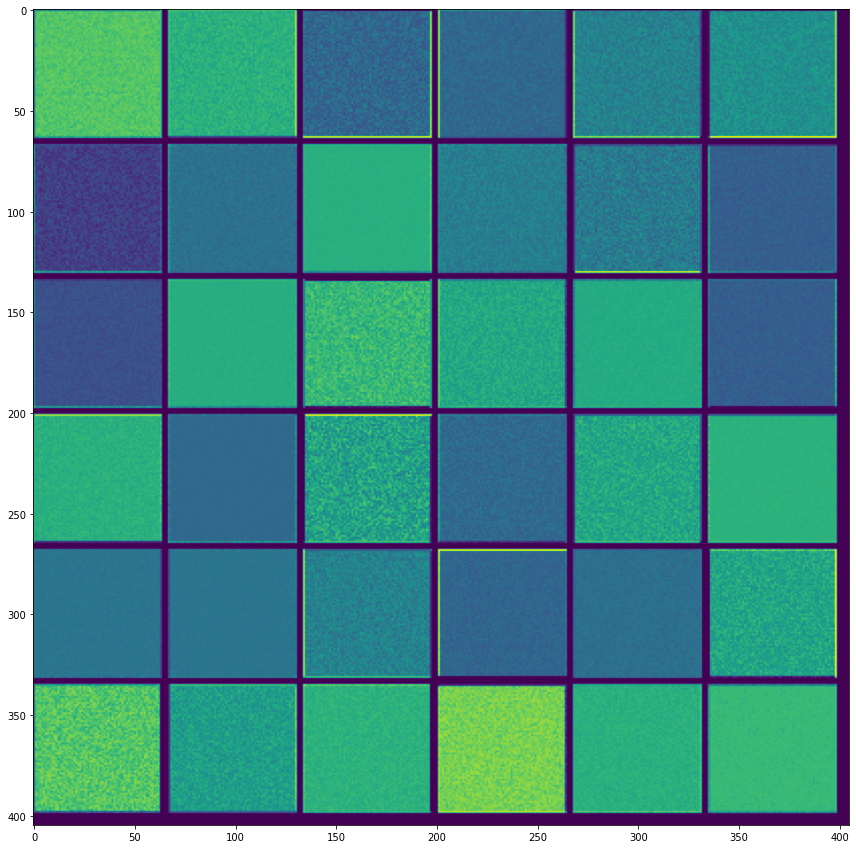

In [0]:
plot_filters(model, ['conv2d_1'], 64, 3, row = 6, col = 6, greyscale_flag = True, plot_flag=False)

### Conv2D_2

In [0]:
conv2d_2 = get_filter_array(model, 'conv2d_2', 18)

In [0]:
conv2d_2_ssim = calculate_dist(conv2d_2, method="ssim")
get_cluster_(conv2d_2_ssim, weight=0.738, row=3, col=6, min_samp=1)

Calculated Distance Matrix Using ssim Method.
Filter number: 18
[[0 0 1 0 2 3]
 [0 4 5 0 0 6]
 [7 0 0 8 9 0]]


array([[0, 0, 1, 0, 2, 3],
       [0, 4, 5, 0, 0, 6],
       [7, 0, 0, 8, 9, 0]])

In [0]:
conv2d_2_mse = calculate_dist(conv2d_2, method="imed")
get_cluster_(conv2d_2_mse, weight=0.32, row=3, col=6, min_samp=1)

Calculated Distance Matrix Using imed Method.
Filter number: 18
[[ 0  0  1  2  3  4]
 [ 0  5  6  7  7  8]
 [ 9  2  2 10 11  0]]


array([[ 0,  0,  1,  2,  3,  4],
       [ 0,  5,  6,  7,  7,  8],
       [ 9,  2,  2, 10, 11,  0]])

Finished filter no. 5 in conv2d_2.  Finished filter no. 8 in conv2d_2.  Finished filter no. 11 in conv2d_2.  conv2d_2


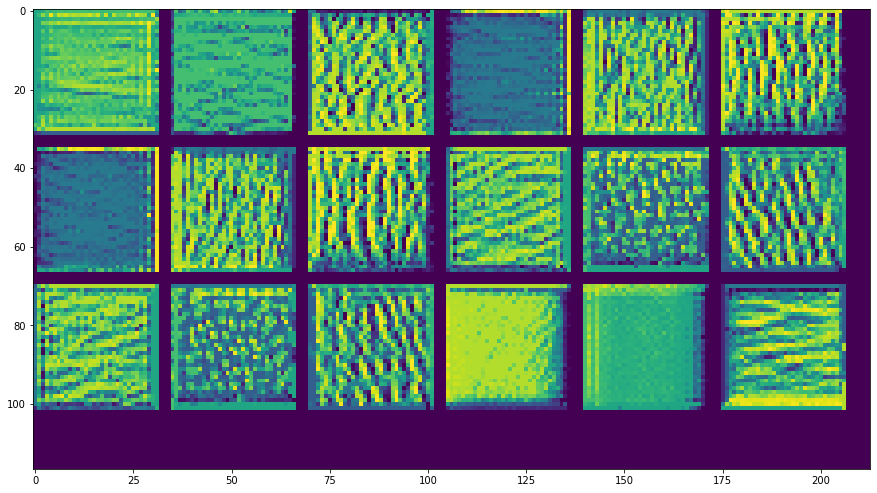

In [0]:
plot_filters(model, ['conv2d_2'], 32, 3, row = 3, col = 6, greyscale_flag = True, plot_flag=False)

Finished filter no. 5 in conv2d_2.  Finished filter no. 8 in conv2d_2.  Finished filter no. 11 in conv2d_2.  conv2d_2


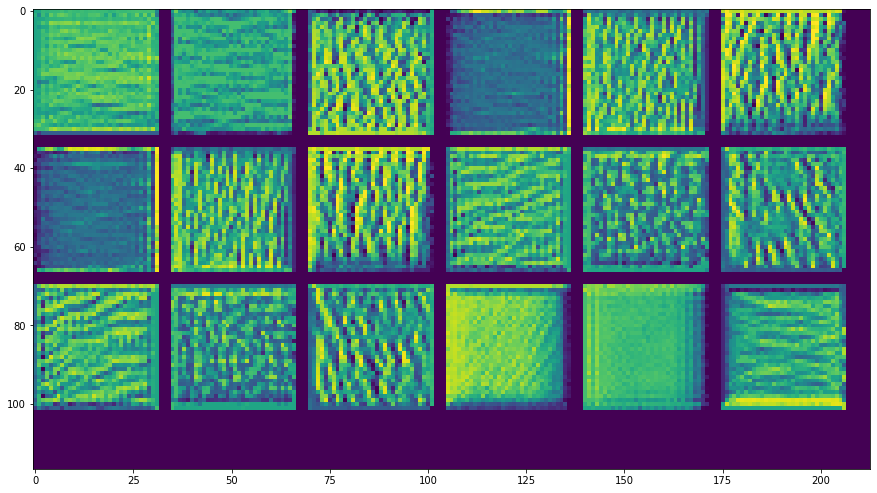

In [0]:
plot_filters(model, ['conv2d_2'], 32, 3, row = 3, col = 6, greyscale_flag = True, plot_flag=False)

Finished filter no. 5 in conv2d_2.  Finished filter no. 8 in conv2d_2.  Finished filter no. 11 in conv2d_2.  conv2d_2


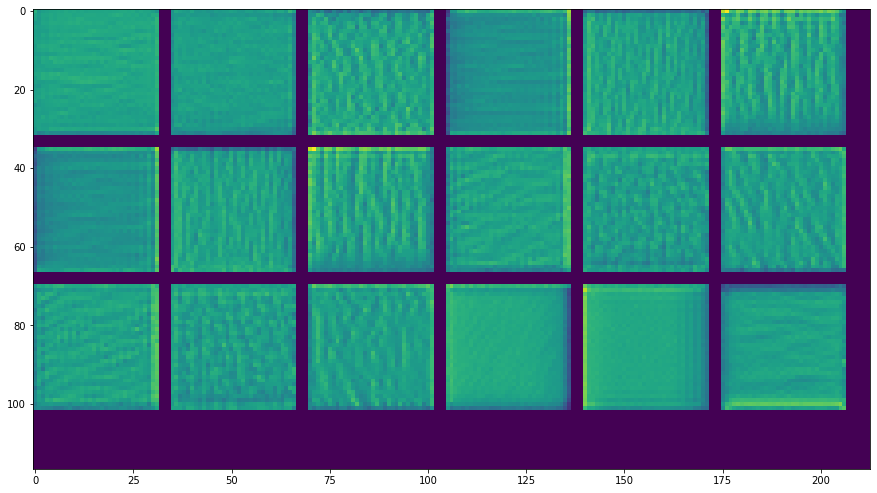

In [0]:
plot_filters(model, ['conv2d_2'], 32, 3, row = 3, col = 6, greyscale_flag = True, plot_flag=True)

### Conv2D_14

In [0]:
# conv2d_14 = get_filter_array(model, 'conv2d_4', 18)
conv2d_14_mse = calculate_dist(conv2d_14, method="ssim")
get_cluster_(conv2d_14_mse, weight=13, row=3, col=6, min_samp=1)

[[0 1 2 3 2 4]
 [2 5 2 2 6 2]
 [7 2 2 8 2 9]]


In [0]:
conv2d_14.shape

(18, 32, 32)

Finished filter no. 5 in conv2d_14.  Finished filter no. 8 in conv2d_14.  Finished filter no. 11 in conv2d_14.  conv2d_14


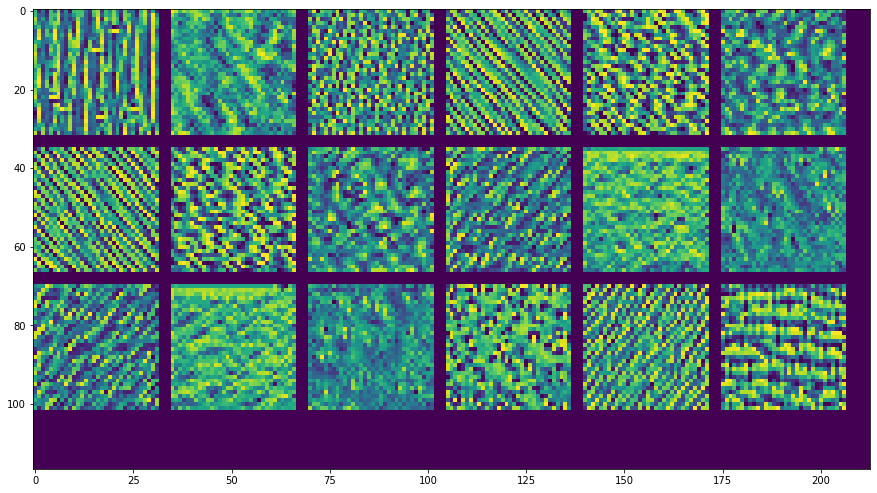

In [0]:
plot_filters(model, ['conv2d_14'], 32, 3, row = 3, col = 6, greyscale_flag = True, plot_flag=False)

Finished filter no. 5 in conv2d_67.  Finished filter no. 8 in conv2d_67.  Finished filter no. 11 in conv2d_67.  conv2d_67


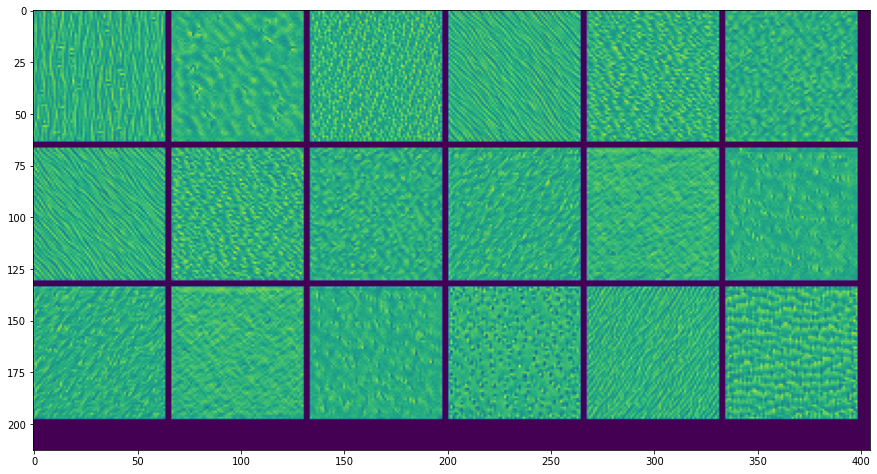

In [0]:
plot_filters(model_64, ['conv2d_67'], 64, 3, row = 3, col = 6, greyscale_flag = True, plot_flag=False)

Finished filter no. 5 in conv2d_67.  Finished filter no. 8 in conv2d_67.  Finished filter no. 11 in conv2d_67.  conv2d_67


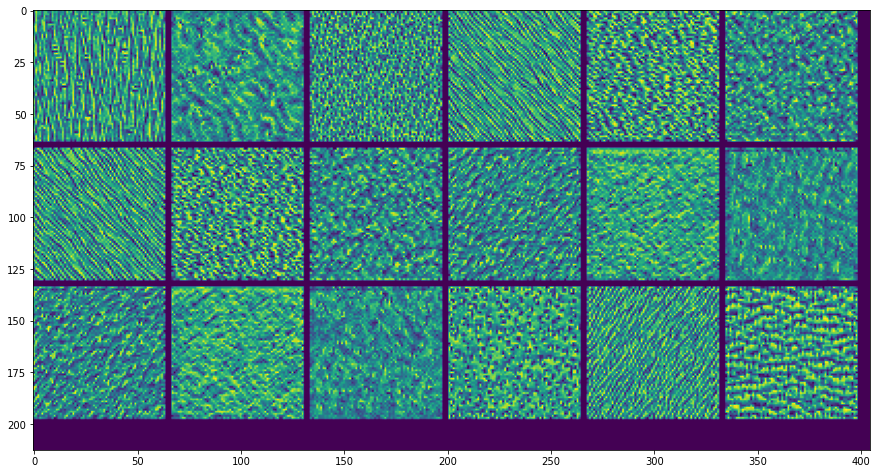

In [0]:
plot_filters(model_64, ['conv2d_67'], 64, 3, row = 3, col = 6, greyscale_flag = True, plot_flag=False)

$$\sum_{i=1}^{1024}{\frac{(x_i - y_i)^2}$$
